# SPRINT 5: Unsupervised Learning - Clustering

## Objective
In this notebook, we shift our perspective from supervised to **unsupervised learning**. Our goal is no longer to predict a known outcome, but to explore the inherent structure of the data itself. We will use clustering algorithms to see if we can identify natural groupings or "clusters" of patients based on their medical features, without using the `target` variable.

### Methods to be Used:
- **K-Means Clustering**
- **Hierarchical Clustering**

In [1]:
# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch # For Hierarchical Clustering

# Set plot style
sns.set_style('whitegrid')

# --- 2. Load the Processed Data ---
# We use the fully scaled and encoded data from notebook 01.
PROCESSED_DATA_PATH = '../data/heart_disease_processed.csv'
df = pd.read_csv(PROCESSED_DATA_PATH)

# --- 3. Prepare the data for clustering ---
# Unsupervised learning works on features only. We do not need the target variable.
X_cluster = df.drop('target', axis=1)

# --- 4. Verify the data ---
print("--- Shape of our data for Clustering ---")
print("X_cluster shape:", X_cluster.shape)

print("\n--- First 5 rows of the clustering data ---")
X_cluster.head()

--- Shape of our data for Clustering ---
X_cluster shape: (303, 18)

--- First 5 rows of the clustering data ---


,age,trestbps,chol,thalach,oldpeak,ca,sex_1.0,cp_2.0,cp_3.0,cp_4.0,fbs_1.0,restecg_1.0,restecg_2.0,exang_1.0,slope_2.0,slope_3.0,thal_6.0,thal_7.0
0,0.948726,0.757525,-0.264900,0.017197,1.087338,0.0,True,False,False,False,True,False,True,False,False,True,True,False
1,1.392002,1.611220,0.760415,-1.821905,0.397182,3.0,True,False,False,True,False,False,True,True,True,False,False,False
2,1.392002,-0.665300,-0.342283,-0.902354,1.346147,2.0,True,False,False,True,False,False,True,True,True,False,False,True
3,-1.932564,-0.096170,0.063974,1.637359,2.122573,0.0,True,False,True,False,False,False,False,False,False,True,False,False
4,-1.489288,-0.096170,-0.825922,0.980537,0.310912,0.0,False,True,False,False,False,False,True,False,False,False,False,False


## Step 2: K-Means Clustering - The Elbow Method

Our first clustering algorithm is K-Means. A critical prerequisite for this algorithm is to specify the number of clusters (`k`) we want the data to be grouped into. To find the optimal `k`, we will use the **Elbow Method**.

This method involves running the K-Means algorithm multiple times for a range of `k` values (e.g., 1 to 10). For each run, we record the **WCSS (Within-Cluster Sum of Squares)**, which measures how compact the clusters are. We then plot these values. The "elbow" of the resulting curve—the point where the rate of decrease sharply changes—is considered the optimal number of clusters.

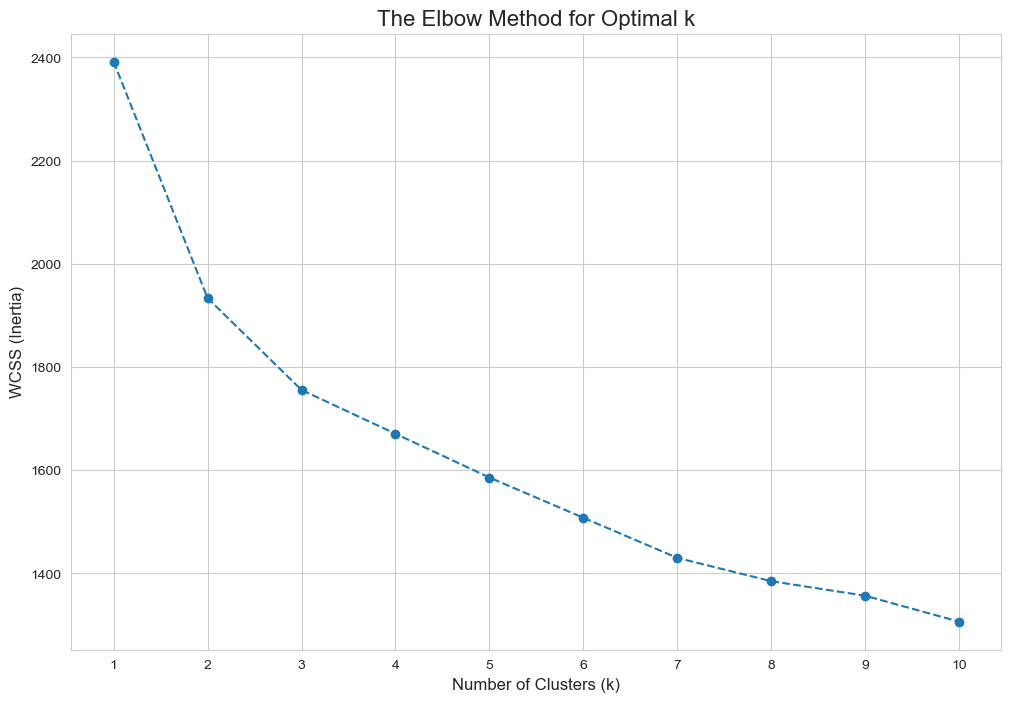

In [2]:
# --- 1. Find the optimal number of clusters using the Elbow Method ---
wcss = [] # Within-Cluster Sum of Squares
cluster_range = range(1, 11)

for i in cluster_range:
    # We use n_init='auto' to avoid a future warning.
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(X_cluster)
    wcss.append(kmeans.inertia_)

# --- 2. Plot the Elbow Method graph ---
plt.figure(figsize=(12, 8))
plt.plot(cluster_range, wcss, marker='o', linestyle='--')
plt.title('The Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('WCSS (Inertia)', fontsize=12)
plt.xticks(cluster_range)
plt.grid(True)
plt.savefig('../results/kmeans_elbow_method.png')
plt.show()

## Step 3: Applying K-Means with Optimal k and Visualizing Clusters

**Interpreting the Plot:** Looking at the elbow plot, we can see the rate of decrease in WCSS slows down significantly after **k=2** and **k=3**. While the "elbow" is not perfectly sharp, `k=2` is a strong candidate as it represents a natural binary grouping which might correspond to healthier vs. less-healthy patient profiles. Let's proceed by choosing **2** as our optimal number of clusters.

**Objective:** We will now run the K-Means algorithm with `n_clusters=2`. To visualize the resulting clusters from our high-dimensional data, we will first use PCA to reduce the data to two principal components and then create a scatter plot.

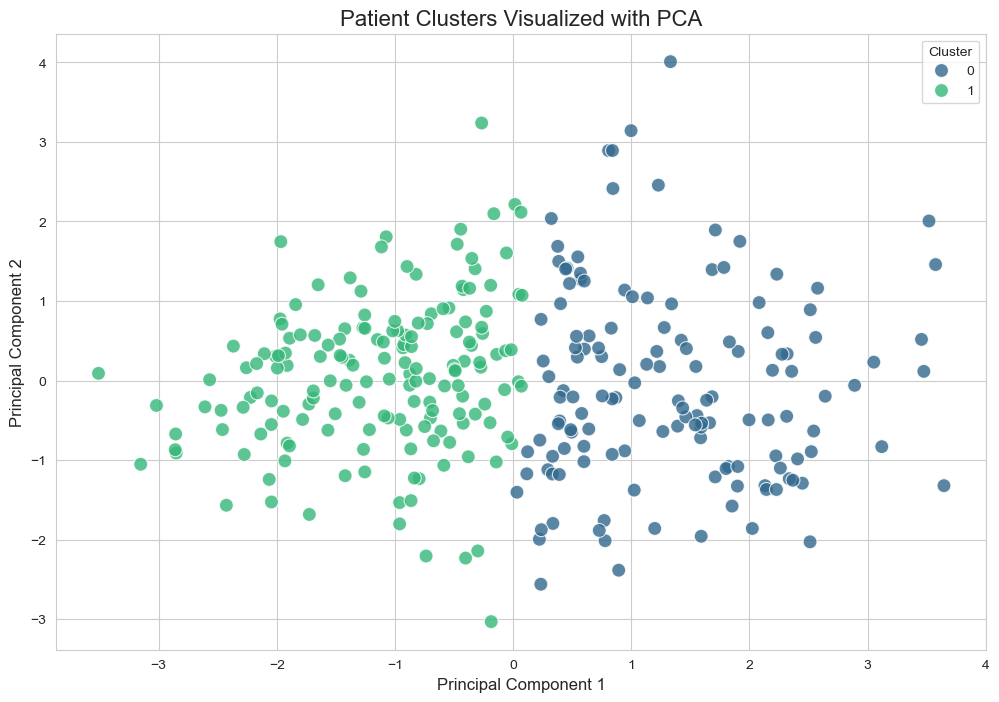

In [3]:
# --- 1. Apply K-Means with the optimal number of clusters ---
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X_cluster)

# --- 2. Add the cluster labels to our original data ---
X_cluster_labeled = X_cluster.copy()
X_cluster_labeled['cluster'] = cluster_labels

# --- 3. Use PCA to reduce data to 2 dimensions for visualization ---
# FIX: We need to import the PCA class in this notebook before we can use it.
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca_2d = pca.fit_transform(X_cluster)

# Create a DataFrame for the 2D data
df_pca_2d = pd.DataFrame(data=X_pca_2d, columns=['PC1', 'PC2'])
df_pca_2d['cluster'] = cluster_labels

# --- 4. Visualize the clusters ---
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_pca_2d, palette='viridis', s=100, alpha=0.8)
plt.title('Patient Clusters Visualized with PCA', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig('../results/kmeans_clusters_visualization.png')
plt.show()

## Step 4: Hierarchical Clustering with a Dendrogram

Our second unsupervised learning method is **Hierarchical Clustering**. Unlike K-Means, this method does not require us to specify the number of clusters beforehand. Instead, it builds a hierarchy of potential clusters.

We will visualize this hierarchy using a **Dendrogram**. By looking for the longest vertical lines in the dendrogram, we can get a good idea of the natural number of clusters present in the data.

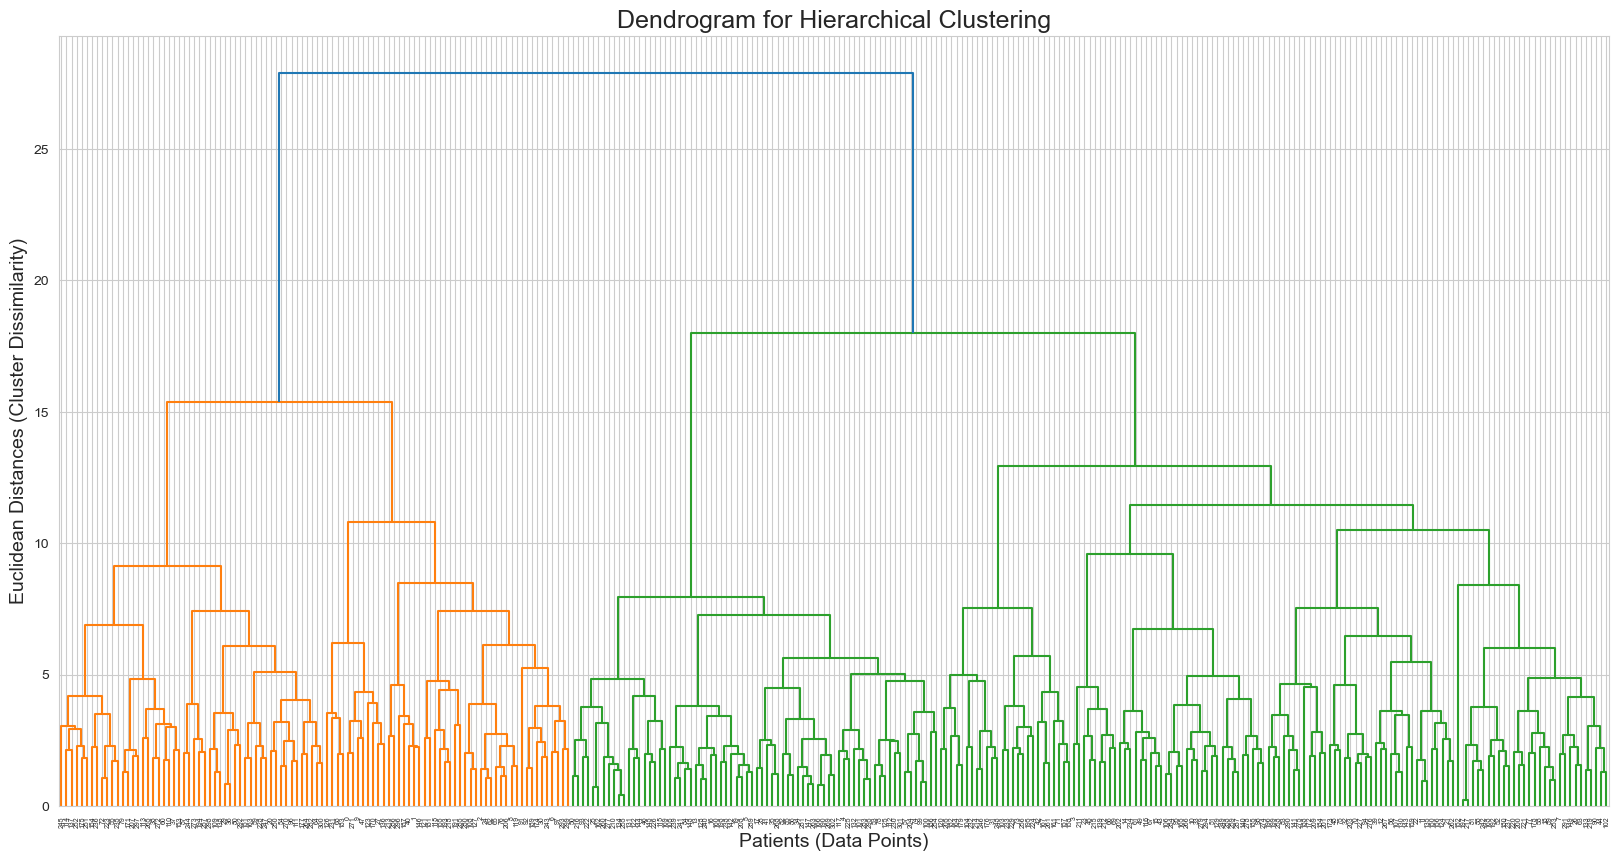

In [4]:
# --- 1. Create the Dendrogram ---
# We use the 'ward' method, which minimizes the variance within each cluster.
plt.figure(figsize=(20, 10))
dendrogram = sch.dendrogram(sch.linkage(X_cluster, method='ward'))

# --- 2. Configure and show the plot ---
plt.title('Dendrogram for Hierarchical Clustering', fontsize=18)
plt.xlabel('Patients (Data Points)', fontsize=14)
plt.ylabel('Euclidean Distances (Cluster Dissimilarity)', fontsize=14)
plt.savefig('../results/hierarchical_clustering_dendrogram.png')
plt.show()

In [5]:
# --- Save the data with cluster assignments ---

# The DataFrame 'X_cluster_labeled' already contains our data with the new 'cluster' column.
CLUSTER_RESULTS_PATH = '../results/patient_cluster_assignments.csv'

# Save this DataFrame to a CSV file.
X_cluster_labeled.to_csv(CLUSTER_RESULTS_PATH, index=False)

print(f"Data with cluster labels has been successfully saved to: {CLUSTER_RESULTS_PATH}")
print("\n--- Mission Accomplished for Notebook 05! ---")

Data with cluster labels has been successfully saved to: ../results/patient_cluster_assignments.csv

--- Mission Accomplished for Notebook 05! ---
